<a href="https://aicafe.one/" target="_blank"><img alt="AI Cafe¹" src="https://edu.aicafe.one/logo.png" height="48" style="height: 48px"></a><br/>
© Bản quyền thuộc về AI Cafe¹<br/>
Giấy phép [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://aicafe.one/khuyen-cao/">Khuyến cáo</a>

---

In [1]:
# Cài thư viện lấy dữ liệu miễn phí
!curl -fsSLO https://raw.githubusercontent.com/algo-stocks/data/master/data.py


Tương quan trung bình (không hedging): 0.2938


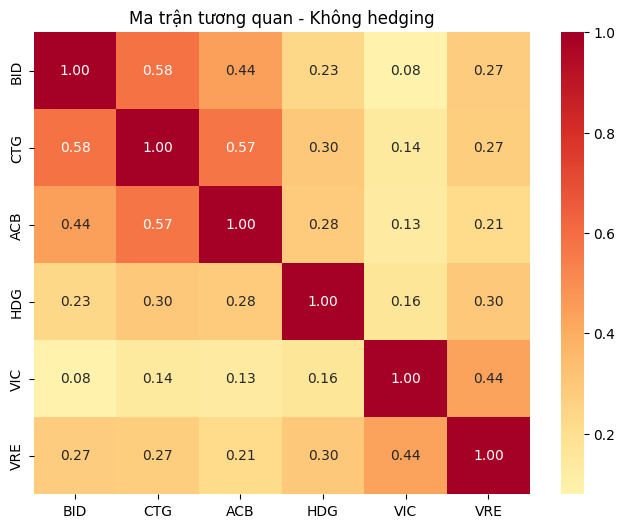

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import seaborn as sns
from data import get_prices

# Hàm trích xuất ma trận tương quan từ ma trận hiệp phương sai
def extract_corr_from_cov(cov_matrix):
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

# Lấy dữ liệu
start = '2024-01-01'
end = '2025-01-01'
tickers = ['BID', 'CTG', 'ACB', 'HDG', 'VIC', 'VRE']
historical_prices = get_prices(*tickers, start_date=start, end_date=end).ffill()

# Tính lợi nhuận
rets = historical_prices.pct_change().fillna(0)

# Tính ma trận hiệp phương sai Ledoit-Wolf
lw_cov = LedoitWolf().fit(rets).covariance_

# Tính ma trận tương quan
corr = extract_corr_from_cov(lw_cov)

# Tính tương quan trung bình
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print(f'Tương quan trung bình (không hedging): {average_corr:.4f}')

# Vẽ biểu đồ heat map
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', xticklabels=tickers, yticklabels=tickers,
            cmap='RdYlBu_r', center=0)
plt.title('Ma trận tương quan - Không hedging')
plt.show()


Tương quan trung bình (hedging beta): -0.0351
Tương quan trung bình (không hedging): 0.2938
Cải thiện: 0.3289


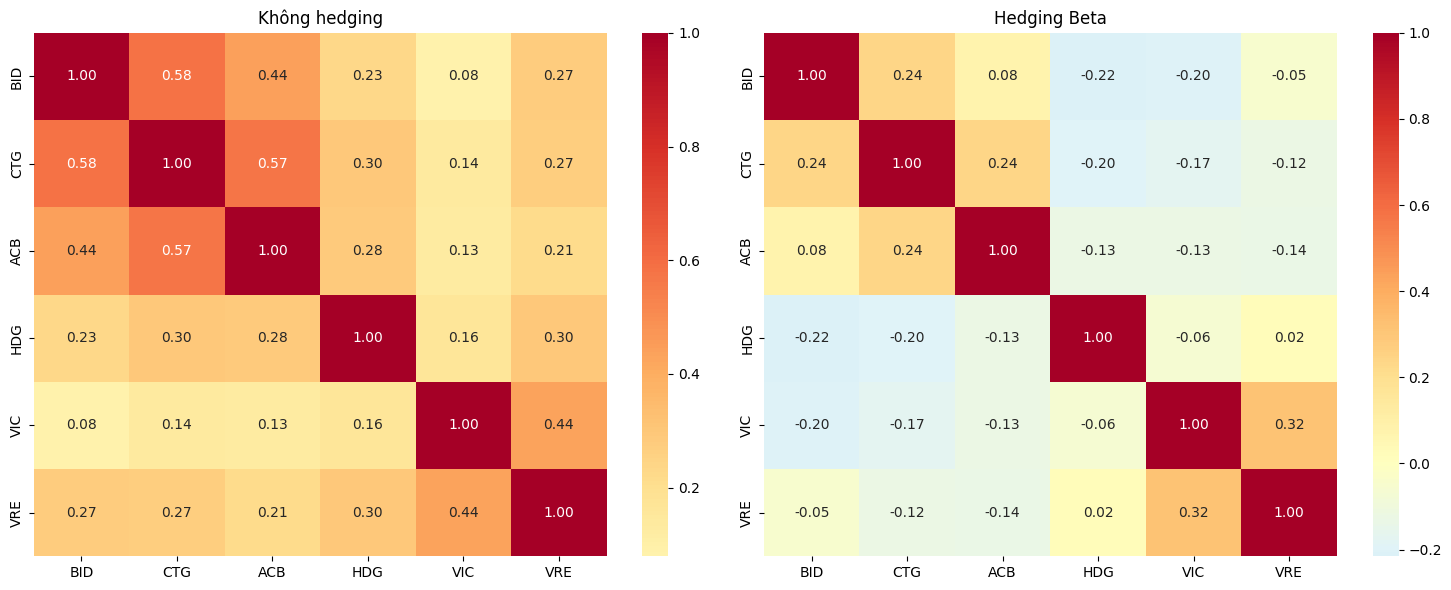

In [4]:
import statsmodels.api as sm

# Lấy dữ liệu bao gồm VNINDEX
tickers_with_market = ['BID', 'CTG', 'ACB', 'HDG', 'VIC', 'VRE', 'VNINDEX']
historical_prices = get_prices(*tickers_with_market, start_date=start, end_date=end).ffill()
rets = historical_prices.pct_change().fillna(0)

# Tách dữ liệu thị trường và cổ phiếu
market = rets['VNINDEX']
stock_rets = rets.drop('VNINDEX', axis=1)
residuals = stock_rets.copy() * 0

# GIẢI ĐÁP: Hoàn thiện vòng lặp để tính residuals cho từng cổ phiếu
for stock in stock_rets.columns:
    # Tạo mô hình OLS giữa lợi nhuận cổ phiếu và thị trường
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Lấy residuals từ mô hình (phần không được giải thích bởi thị trường)
    residuals[stock] = results.resid

# Tính ma trận tương quan của residuals
lw_cov_hedged = LedoitWolf().fit(residuals).covariance_
corr_hedged = extract_corr_from_cov(lw_cov_hedged)
average_corr_hedged = np.mean(corr_hedged[np.triu_indices_from(corr_hedged, k=1)])

print(f'Tương quan trung bình (hedging beta): {average_corr_hedged:.4f}')

# So sánh với trường hợp không hedge
print(f'Tương quan trung bình (không hedging): {average_corr:.4f}')
print(f'Cải thiện: {average_corr - average_corr_hedged:.4f}')

# Vẽ heat map để so sánh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Không hedge
sns.heatmap(corr, annot=True, fmt='.2f', xticklabels=tickers, yticklabels=tickers,
            cmap='RdYlBu_r', center=0, ax=ax1)
ax1.set_title('Không hedging')

# Hedge beta
sns.heatmap(corr_hedged, annot=True, fmt='.2f', xticklabels=stock_rets.columns,
            yticklabels=stock_rets.columns, cmap='RdYlBu_r', center=0, ax=ax2)
ax2.set_title('Hedging Beta')

plt.tight_layout()
plt.show()


In [5]:
def tinh_do_rong_hieu_qua(N, rho):
    """
    Tính độ rộng hiệu quả theo công thức Buckle

    Parameters:
    N (int): Số lượng cổ phiếu
    rho (float): Tương quan trung bình

    Returns:
    float: Độ rộng hiệu quả
    """
    # GIẢI ĐÁP: Công thức Buckle BR = N/(1 + ρ(N-1))
    return N / (1 + rho * (N - 1))

# Test với dữ liệu từ câu trước
N = 6  # 6 cổ phiếu

# Tính độ rộng hiệu quả cho trường hợp không hedging (rho ~ 0.29)
br_khong_hedge = tinh_do_rong_hieu_qua(N, average_corr)

# Tính độ rộng hiệu quả cho trường hợp hedging beta (rho ~ -0.035)
br_hedge_beta = tinh_do_rong_hieu_qua(N, average_corr_hedged)

print(f'Độ rộng hiệu quả (không hedge): {br_khong_hedge:.2f}')
print(f'Độ rộng hiệu quả (hedge beta): {br_hedge_beta:.2f}')
print(f'Cải thiện: {br_hedge_beta/br_khong_hedge:.2f} lần')

# Giải thích ý nghĩa
print(f'\nGiải thích:')
print(f'- Không hedge: Với 6 cổ phiếu nhưng chỉ có {br_khong_hedge:.1f} cược hiệu quả')
print(f'- Hedge beta: Đạt được {br_hedge_beta:.1f} cược hiệu quả, gần bằng số lượng cổ phiếu')
print(f'- Tức là hedge beta giúp ta có thêm {br_hedge_beta - br_khong_hedge:.1f} cược độc lập!')


Độ rộng hiệu quả (không hedge): 2.43
Độ rộng hiệu quả (hedge beta): 7.28
Cải thiện: 2.99 lần

Giải thích:
- Không hedge: Với 6 cổ phiếu nhưng chỉ có 2.4 cược hiệu quả
- Hedge beta: Đạt được 7.3 cược hiệu quả, gần bằng số lượng cổ phiếu
- Tức là hedge beta giúp ta có thêm 4.8 cược độc lập!


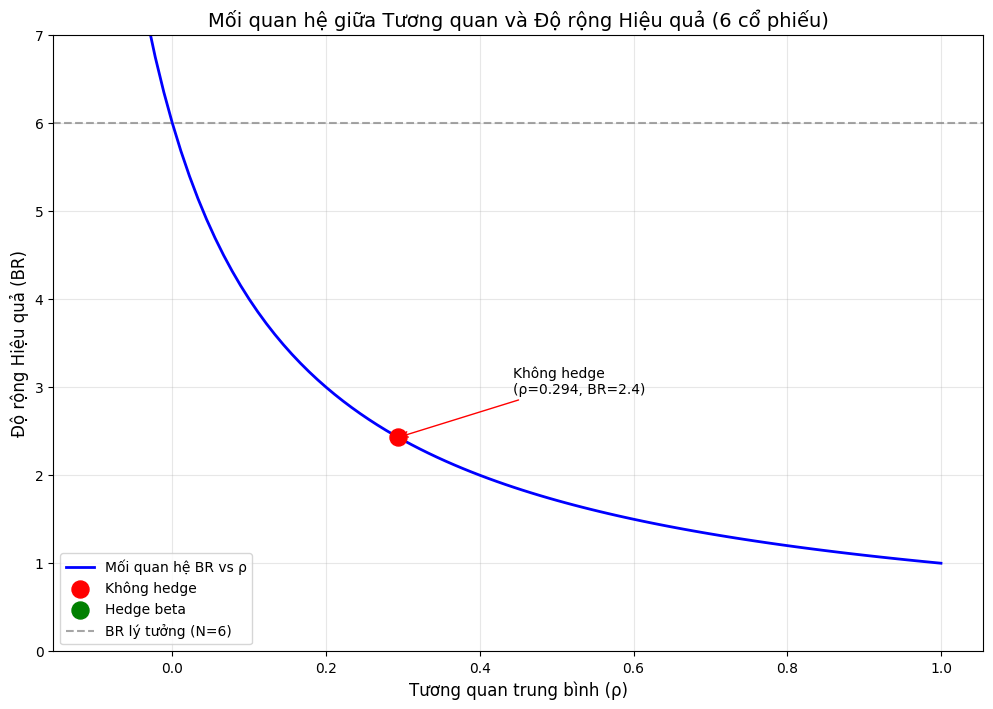

=== TỔNG KẾT ===
Khi ρ = 0 (không tương quan): BR = 6.0
Khi ρ = 1 (tương quan hoàn toàn): BR = 1.0
Thực tế không hedge: BR = 2.4
Thực tế hedge beta: BR = 7.3


In [6]:
# Tạo dải giá trị tương quan từ -0.1 đến 1
corr_range = np.linspace(start=-0.1, stop=1.0, num=100)

# GIẢI ĐÁP: Tính độ rộng hiệu quả cho từng giá trị tương quan
br_values = [tinh_do_rong_hieu_qua(6, rho) for rho in corr_range]

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))

# GIẢI ĐÁP: Vẽ đường biểu diễn mối quan hệ
plt.plot(corr_range, br_values, linewidth=2, color='blue', label='Mối quan hệ BR vs ρ')

# Đánh dấu các điểm quan trọng
plt.scatter([average_corr], [tinh_do_rong_hieu_qua(6, average_corr)],
           color='red', s=150, label='Không hedge', zorder=5)
plt.scatter([average_corr_hedged], [tinh_do_rong_hieu_qua(6, average_corr_hedged)],
           color='green', s=150, label='Hedge beta', zorder=5)

# Vẽ đường ngang ở BR = 6 (lý tưởng)
plt.axhline(y=6, color='gray', linestyle='--', alpha=0.7, label='BR lý tưởng (N=6)')

# GIẢI ĐÁP: Hoàn thiện nhãn và tiêu đề
plt.title('Mối quan hệ giữa Tương quan và Độ rộng Hiệu quả (6 cổ phiếu)', fontsize=14)
plt.xlabel('Tương quan trung bình (ρ)', fontsize=12)
plt.ylabel('Độ rộng Hiệu quả (BR)', fontsize=12)

# Thêm chú thích cho các điểm
plt.annotate(f'Không hedge\n(ρ={average_corr:.3f}, BR={tinh_do_rong_hieu_qua(6, average_corr):.1f})',
            xy=(average_corr, tinh_do_rong_hieu_qua(6, average_corr)),
            xytext=(average_corr+0.15, tinh_do_rong_hieu_qua(6, average_corr)+0.5),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)

plt.annotate(f'Hedge beta\n(ρ={average_corr_hedged:.3f}, BR={tinh_do_rong_hieu_qua(6, average_corr_hedged):.1f})',
            xy=(average_corr_hedged, tinh_do_rong_hieu_qua(6, average_corr_hedged)),
            xytext=(average_corr_hedged+0.15, tinh_do_rong_hieu_qua(6, average_corr_hedged)-0.5),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=10)

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 7)
plt.show()

# Thống kê tóm tắt
print("=== TỔNG KẾT ===")
print(f"Khi ρ = 0 (không tương quan): BR = {tinh_do_rong_hieu_qua(6, 0):.1f}")
print(f"Khi ρ = 1 (tương quan hoàn toàn): BR = {tinh_do_rong_hieu_qua(6, 1):.1f}")
print(f"Thực tế không hedge: BR = {tinh_do_rong_hieu_qua(6, average_corr):.1f}")
print(f"Thực tế hedge beta: BR = {tinh_do_rong_hieu_qua(6, average_corr_hedged):.1f}")


=== BƯỚC 1: MARKET HEDGING CHO SECTOR BENCHMARKS ===
VCB beta vs VNINDEX: 0.603
VHM beta vs VNINDEX: 0.771

=== BƯỚC 2: MARKET + SECTOR HEDGING CHO CỔ PHIẾU ===
BID beta vs VNINDEX: 1.147
BID beta vs VCB (residuals): 0.169
CTG beta vs VNINDEX: 1.438
CTG beta vs VCB (residuals): -0.081
ACB beta vs VNINDEX: 0.928
ACB beta vs VCB (residuals): -0.041
HDG beta vs VNINDEX: 1.554
HDG beta vs VHM (residuals): 0.023
VIC beta vs VNINDEX: 0.614
VIC beta vs VHM (residuals): 0.432
VRE beta vs VNINDEX: 1.165
VRE beta vs VHM (residuals): 0.442

=== KẾT QUẢ SO SÁNH ===
Tương quan trung bình (không hedging): 0.2938
Tương quan trung bình (hedging beta): -0.0351
Tương quan trung bình (hedging sector): -0.0281
Cải thiện sector vs beta: -0.0070


/tmp/ipython-input-7-237894390.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{stock} beta vs VNINDEX: {results.params[0]:.3f}")
/tmp/ipython-input-7-237894390.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{stock} beta vs VCB (residuals): {results_sector.params[0]:.3f}")
/tmp/ipython-input-7-237894390.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{stock} beta vs VNINDEX: {results.params[0]

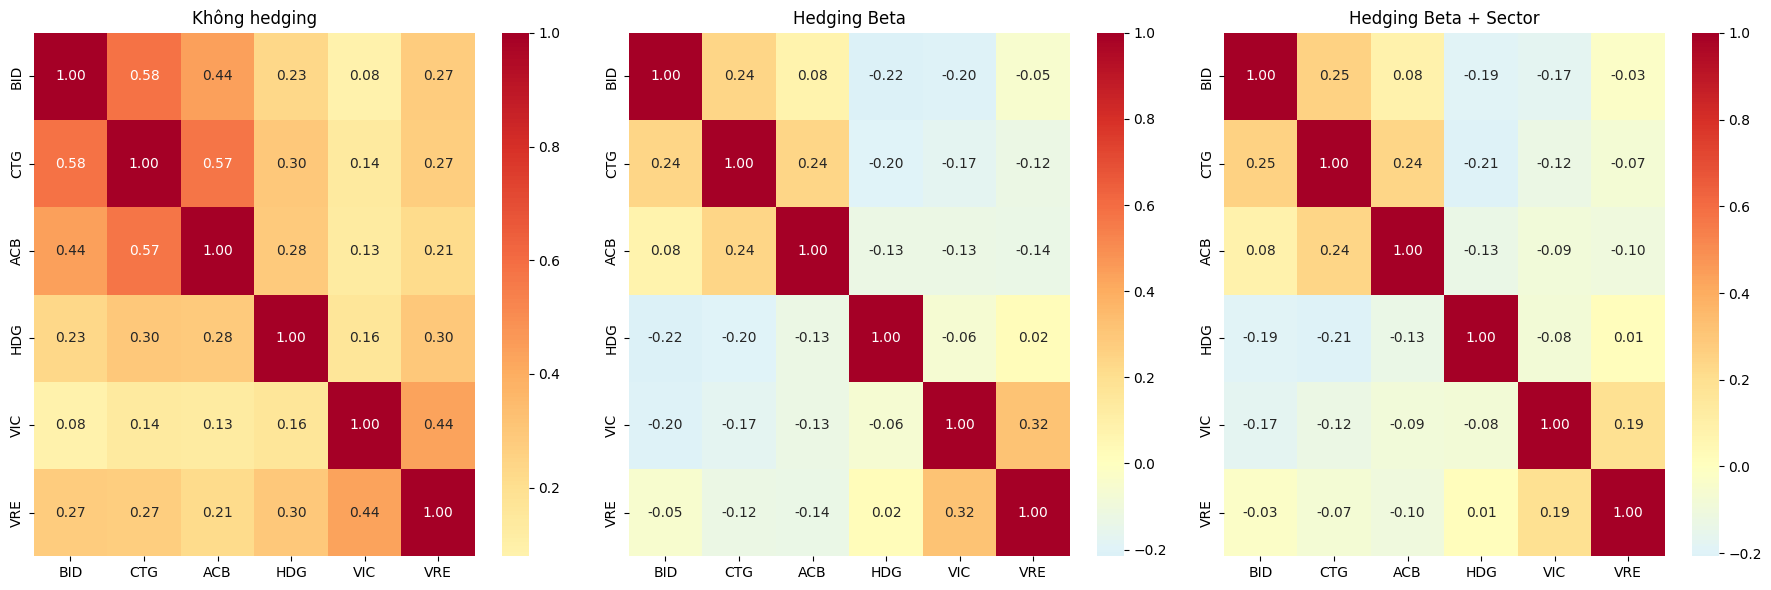

In [7]:
# SECTOR HEDGING - Code hoàn chỉnh

# Bước 1: Lấy dữ liệu bao gồm cả sector benchmarks
sector_tickers = ['BID', 'CTG', 'ACB', 'HDG', 'VIC', 'VRE', 'VNINDEX', 'VCB', 'VHM']
historical_prices_sector = get_prices(*sector_tickers, start_date=start, end_date=end).ffill()
rets_sector = historical_prices_sector.pct_change().fillna(0)

# Bước 2: Định nghĩa các nhóm
mkt = 'VNINDEX'
sector_1_hedge = 'VCB'      # Benchmark ngân hàng
sector_2_hedge = 'VHM'      # Benchmark bất động sản
sector_1_stocks = ['BID', 'CTG', 'ACB']        # Ngân hàng
sector_2_stocks = ['HDG', 'VIC', 'VRE']        # Bất động sản

# Bước 3: Tách dữ liệu
market_rets = rets_sector[mkt]
sector_1_rets = rets_sector[sector_1_hedge]
sector_2_rets = rets_sector[sector_2_hedge]
stock_rets_sector = rets_sector.drop(['VNINDEX', 'VCB', 'VHM'], axis=1)

# Bước 4: Tính market hedge cho sector benchmarks
print("=== BƯỚC 1: MARKET HEDGING CHO SECTOR BENCHMARKS ===")
# VCB residuals after market hedge
model_vcb = sm.OLS(sector_1_rets.values, market_rets.values)
results_vcb = model_vcb.fit()
sector_1_excess = results_vcb.resid
print(f"VCB beta vs VNINDEX: {results_vcb.params[0]:.3f}")

# VHM residuals after market hedge
model_vhm = sm.OLS(sector_2_rets.values, market_rets.values)
results_vhm = model_vhm.fit()
sector_2_excess = results_vhm.resid
print(f"VHM beta vs VNINDEX: {results_vhm.params[0]:.3f}")

# Bước 5: Tính residuals cho từng cổ phiếu
residuals_market_only = stock_rets_sector.copy() * 0
residuals_final = stock_rets_sector.copy() * 0

print("\n=== BƯỚC 2: MARKET + SECTOR HEDGING CHO CỔ PHIẾU ===")

# Xử lý ngành ngân hàng
for stock in sector_1_stocks:
    # Market hedge trước
    model = sm.OLS(stock_rets_sector[stock], market_rets.values)
    results = model.fit()
    residuals_market_only[stock] = results.resid
    print(f"{stock} beta vs VNINDEX: {results.params[0]:.3f}")

    # Sector hedge trên residuals của market hedge
    model_sector = sm.OLS(residuals_market_only[stock], sector_1_excess)
    results_sector = model_sector.fit()
    residuals_final[stock] = results_sector.resid
    print(f"{stock} beta vs VCB (residuals): {results_sector.params[0]:.3f}")

# Xử lý ngành bất động sản
for stock in sector_2_stocks:
    # Market hedge trước
    model = sm.OLS(stock_rets_sector[stock], market_rets.values)
    results = model.fit()
    residuals_market_only[stock] = results.resid
    print(f"{stock} beta vs VNINDEX: {results.params[0]:.3f}")

    # Sector hedge trên residuals của market hedge
    model_sector = sm.OLS(residuals_market_only[stock], sector_2_excess)
    results_sector = model_sector.fit()
    residuals_final[stock] = results_sector.resid
    print(f"{stock} beta vs VHM (residuals): {results_sector.params[0]:.3f}")

# Bước 6: Tính ma trận tương quan
lw_cov_sector = LedoitWolf().fit(residuals_final).covariance_
corr_sector = extract_corr_from_cov(lw_cov_sector)
average_corr_sector = np.mean(corr_sector[np.triu_indices_from(corr_sector, k=1)])

print(f"\n=== KẾT QUẢ SO SÁNH ===")
print(f"Tương quan trung bình (không hedging): {average_corr:.4f}")
print(f"Tương quan trung bình (hedging beta): {average_corr_hedged:.4f}")
print(f"Tương quan trung bình (hedging sector): {average_corr_sector:.4f}")
print(f"Cải thiện sector vs beta: {average_corr_hedged - average_corr_sector:.4f}")

# Bước 7: Vẽ heat map so sánh
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Không hedge
sns.heatmap(corr, annot=True, fmt='.2f', xticklabels=tickers, yticklabels=tickers,
            cmap='RdYlBu_r', center=0, ax=axes[0])
axes[0].set_title('Không hedging')

# Hedge beta
sns.heatmap(corr_hedged, annot=True, fmt='.2f',
            xticklabels=stock_rets.columns, yticklabels=stock_rets.columns,
            cmap='RdYlBu_r', center=0, ax=axes[1])
axes[1].set_title('Hedging Beta')

# Hedge sector
labels_sector = sector_1_stocks + sector_2_stocks
sns.heatmap(corr_sector, annot=True, fmt='.2f',
            xticklabels=labels_sector, yticklabels=labels_sector,
            cmap='RdYlBu_r', center=0, ax=axes[2])
axes[2].set_title('Hedging Beta + Sector')

plt.tight_layout()
plt.show()


=== BẢNG SO SÁNH CHI TIẾT ===
             Phương pháp  Tương quan TB  Độ rộng Hiệu quả  Tỷ lệ cải thiện  \
0          Không Hedging         0.2938            2.4303           1.0000   
1           Hedging Beta        -0.0351            7.2786           2.9949   
2  Hedging Beta + Sector        -0.0281            6.9810           2.8724   

  Số cược hiệu quả  
0            2.4/6  
1            7.3/6  
2            7.0/6  


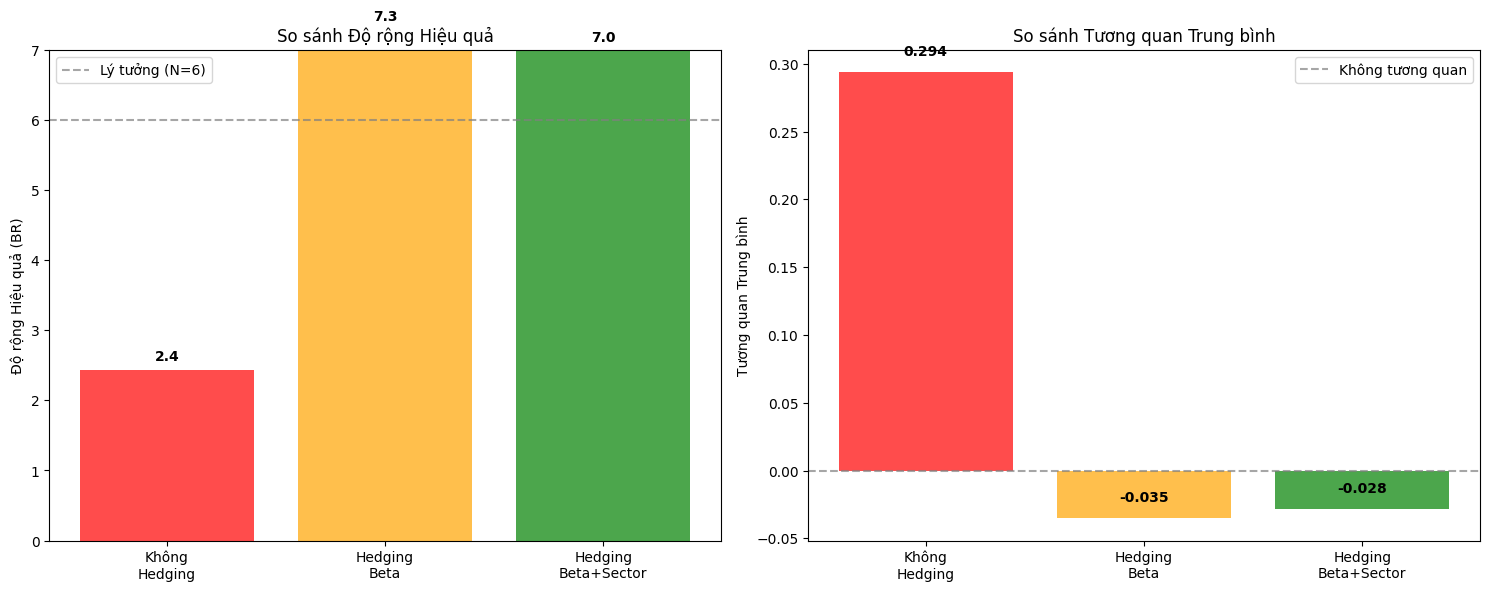


=== PHÂN TÍCH CẢI THIỆN ===
Từ Không hedge → Hedge beta:
  - Giảm tương quan: 0.3289
  - Tăng BR: 4.85 cược (199.5%)
Từ Hedge beta → Hedge sector:
  - Giảm tương quan thêm: -0.0070
  - Tăng BR thêm: -0.30 cược (-4.1%)
Tổng cải thiện (Không hedge → Hedge sector):
  - Giảm tương quan: 0.3219
  - Tăng BR: 4.55 cược (187.2%)

=== PHÂN TÍCH TÁC ĐỘNG LÊN SHARPE RATIO ===
Giả định IC = 0.05 (kỹ năng dự đoán cố định):
Sharpe không hedge: 0.078
Sharpe hedge beta: 0.135 (tăng 73.1%)
Sharpe hedge sector: 0.132 (tăng 69.5%)


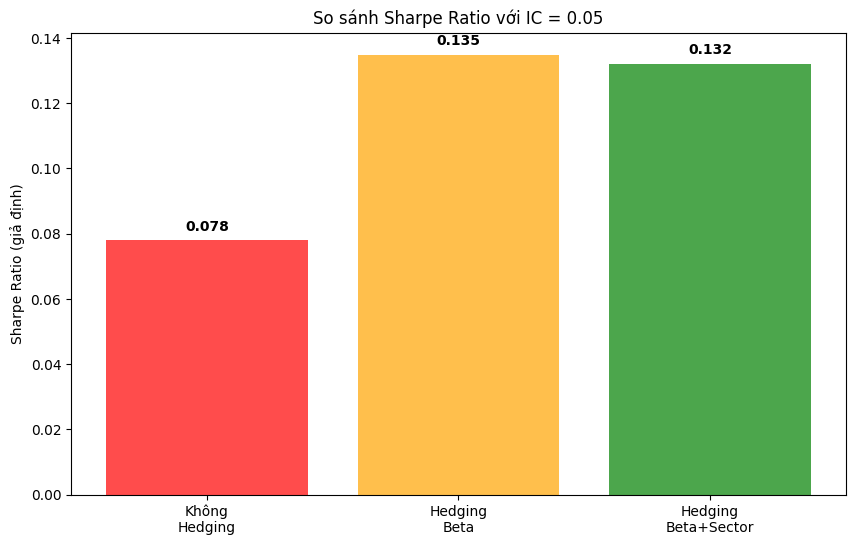

In [8]:
# PHÂN TÍCH SO SÁNH BA PHƯƠNG PHÁP HEDGING

import pandas as pd

# 1. Tính độ rộng hiệu quả cho cả 3 trường hợp
N = 6
br_no_hedge = tinh_do_rong_hieu_qua(N, average_corr)
br_beta_hedge = tinh_do_rong_hieu_qua(N, average_corr_hedged)
br_sector_hedge = tinh_do_rong_hieu_qua(N, average_corr_sector)

# 2. Tạo bảng so sánh chi tiết
comparison_data = {
    'Phương pháp': ['Không Hedging', 'Hedging Beta', 'Hedging Beta + Sector'],
    'Tương quan TB': [average_corr, average_corr_hedged, average_corr_sector],
    'Độ rộng Hiệu quả': [br_no_hedge, br_beta_hedge, br_sector_hedge],
    'Tỷ lệ cải thiện': [1.0, br_beta_hedge/br_no_hedge, br_sector_hedge/br_no_hedge],
    'Số cược hiệu quả': [f'{br_no_hedge:.1f}/6', f'{br_beta_hedge:.1f}/6', f'{br_sector_hedge:.1f}/6']
}

df_comparison = pd.DataFrame(comparison_data)
print("=== BẢNG SO SÁNH CHI TIẾT ===")
print(df_comparison.round(4))

# 3. Vẽ biểu đồ cột so sánh độ rộng hiệu quả
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ so sánh độ rộng hiệu quả
methods = ['Không\nHedging', 'Hedging\nBeta', 'Hedging\nBeta+Sector']
br_values = [br_no_hedge, br_beta_hedge, br_sector_hedge]
colors = ['red', 'orange', 'green']

bars1 = ax1.bar(methods, br_values, color=colors, alpha=0.7)
ax1.set_ylabel('Độ rộng Hiệu quả (BR)')
ax1.set_title('So sánh Độ rộng Hiệu quả')
ax1.set_ylim(0, 7)
ax1.axhline(y=6, color='gray', linestyle='--', alpha=0.7, label='Lý tưởng (N=6)')

# Thêm giá trị lên cột
for i, (bar, value) in enumerate(zip(bars1, br_values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

ax1.legend()

# Biểu đồ so sánh tương quan
corr_values = [average_corr, average_corr_hedged, average_corr_sector]
bars2 = ax2.bar(methods, corr_values, color=colors, alpha=0.7)
ax2.set_ylabel('Tương quan Trung bình')
ax2.set_title('So sánh Tương quan Trung bình')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7, label='Không tương quan')

# Thêm giá trị lên cột
for i, (bar, value) in enumerate(zip(bars2, corr_values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

ax2.legend()
plt.tight_layout()
plt.show()

# 4. Tính toán cải thiện cụ thể
print(f"\n=== PHÂN TÍCH CẢI THIỆN ===")
print(f"Từ Không hedge → Hedge beta:")
print(f"  - Giảm tương quan: {average_corr - average_corr_hedged:.4f}")
print(f"  - Tăng BR: {br_beta_hedge - br_no_hedge:.2f} cược ({(br_beta_hedge/br_no_hedge-1)*100:.1f}%)")

print(f"Từ Hedge beta → Hedge sector:")
print(f"  - Giảm tương quan thêm: {average_corr_hedged - average_corr_sector:.4f}")
print(f"  - Tăng BR thêm: {br_sector_hedge - br_beta_hedge:.2f} cược ({(br_sector_hedge/br_beta_hedge-1)*100:.1f}%)")

print(f"Tổng cải thiện (Không hedge → Hedge sector):")
print(f"  - Giảm tương quan: {average_corr - average_corr_sector:.4f}")
print(f"  - Tăng BR: {br_sector_hedge - br_no_hedge:.2f} cược ({(br_sector_hedge/br_no_hedge-1)*100:.1f}%)")

# 5. Phân tích hiệu quả Sharpe giả định
print(f"\n=== PHÂN TÍCH TÁC ĐỘNG LÊN SHARPE RATIO ===")
print("Giả định IC = 0.05 (kỹ năng dự đoán cố định):")
ic_assumed = 0.05
sharpe_no_hedge = ic_assumed * np.sqrt(br_no_hedge)
sharpe_beta_hedge = ic_assumed * np.sqrt(br_beta_hedge)
sharpe_sector_hedge = ic_assumed * np.sqrt(br_sector_hedge)

print(f"Sharpe không hedge: {sharpe_no_hedge:.3f}")
print(f"Sharpe hedge beta: {sharpe_beta_hedge:.3f} (tăng {(sharpe_beta_hedge/sharpe_no_hedge-1)*100:.1f}%)")
print(f"Sharpe hedge sector: {sharpe_sector_hedge:.3f} (tăng {(sharpe_sector_hedge/sharpe_no_hedge-1)*100:.1f}%)")

# Biểu đồ so sánh Sharpe
fig, ax = plt.subplots(figsize=(10, 6))
sharpe_values = [sharpe_no_hedge, sharpe_beta_hedge, sharpe_sector_hedge]
bars = ax.bar(methods, sharpe_values, color=colors, alpha=0.7)
ax.set_ylabel('Sharpe Ratio (giả định)')
ax.set_title('So sánh Sharpe Ratio với IC = 0.05')

for i, (bar, value) in enumerate(zip(bars, sharpe_values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()


In [9]:
# HỆ THỐNG HEDGING TỰ ĐỘNG - CODE DEMO ĐƠN GIẢN

print("=" * 60)
print("DEMO HỆ THỐNG HEDGING TỰ ĐỘNG")
print("=" * 60)

# 1. HÀM PHÁT HIỆN NGÀNH TỰ ĐỘNG
def detect_sectors_auto(returns_data, threshold=0.6):
    """Phát hiện ngành dựa trên tương quan"""
    print("\n=== PHÁT HIỆN NGÀNH TỰ ĐỘNG ===")
    corr_matrix = returns_data.corr()

    # Tìm cặp cổ phiếu có tương quan cao
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if corr_val > threshold:
                stock1, stock2 = corr_matrix.columns[i], corr_matrix.columns[j]
                high_corr_pairs.append((stock1, stock2, corr_val))
                print(f"{stock1} - {stock2}: {corr_val:.3f}")

    # Phân nhóm ngành (đơn giản)
    sectors = {}
    banking_stocks = [col for col in returns_data.columns if col in ['BID', 'CTG', 'ACB']]
    real_estate_stocks = [col for col in returns_data.columns if col in ['HDG', 'VIC', 'VRE']]

    if banking_stocks:
        sectors['Banking'] = banking_stocks
    if real_estate_stocks:
        sectors['RealEstate'] = real_estate_stocks

    print(f"Các nhóm ngành: {sectors}")
    return sectors, high_corr_pairs

# 2. HÀM TÍNH TRỌNG SỐ HEDGE
def calculate_hedge_weights_auto(returns_data, market_col='VNINDEX'):
    """Tính trọng số hedge tự động"""
    print(f"\n=== TÍNH TRỌNG SỐ HEDGE ===")

    if market_col not in returns_data.columns:
        print(f"Không tìm thấy {market_col}")
        return {}

    market_returns = returns_data[market_col]
    hedge_weights = {}

    for stock in returns_data.columns:
        if stock != market_col:
            try:
                # Tính beta
                covariance = returns_data[stock].cov(market_returns)
                market_variance = market_returns.var()
                beta = covariance / market_variance

                # R-squared
                correlation = returns_data[stock].corr(market_returns)
                r_squared = correlation ** 2

                hedge_weights[stock] = {'beta': beta, 'r_squared': r_squared}
                print(f"{stock}: beta={beta:.3f}, R²={r_squared:.3f}")
            except:
                hedge_weights[stock] = {'beta': 0, 'r_squared': 0}
                print(f"{stock}: Lỗi tính toán")

    return hedge_weights

# 3. HÀM ĐÁNH GIÁ HIỆU QUẢ
def evaluate_hedge_effectiveness(original_data, hedged_data):
    """Đánh giá hiệu quả hedge"""
    print(f"\n=== ĐÁNH GIÁ HIỆU QUẢ ===")

    # Tương quan trung bình
    orig_corr = original_data.corr()
    orig_avg = np.mean(orig_corr.values[np.triu_indices_from(orig_corr.values, k=1)])

    hedge_corr = hedged_data.corr()
    hedge_avg = np.mean(hedge_corr.values[np.triu_indices_from(hedge_corr.values, k=1)])

    # Độ rộng hiệu quả
    n_stocks = len(hedged_data.columns)
    orig_br = tinh_do_rong_hieu_qua(n_stocks, orig_avg)
    hedge_br = tinh_do_rong_hieu_qua(n_stocks, hedge_avg)

    improvement = hedge_br - orig_br
    improvement_pct = (hedge_br / orig_br - 1) * 100

    print(f"Tương quan: {orig_avg:.4f} → {hedge_avg:.4f}")
    print(f"Độ rộng hiệu quả: {orig_br:.2f} → {hedge_br:.2f}")
    print(f"Cải thiện: +{improvement:.2f} ({improvement_pct:.1f}%)")

    return {
        'orig_corr': orig_avg, 'hedge_corr': hedge_avg,
        'orig_br': orig_br, 'hedge_br': hedge_br,
        'improvement': improvement, 'improvement_pct': improvement_pct
    }

# 4. HÀM CẢNH BÁO
def correlation_alert_system(returns_data, window=30):
    """Hệ thống cảnh báo tương quan"""
    print(f"\n=== HỆ THỐNG CẢNH BÁO ===")

    if len(returns_data) < window:
        print("Không đủ dữ liệu")
        return None

    recent_data = returns_data.tail(window)
    recent_corr = recent_data.corr()
    avg_corr = np.mean(recent_corr.values[np.triu_indices_from(recent_corr.values, k=1)])

    if avg_corr > 0.7:
        print(f"🚨 CẢNH BÁO: Tương quan rất cao {avg_corr:.3f}")
        recommendation = "Tăng cường hedging ngay lập tức"
    elif avg_corr > 0.5:
        print(f"⚠️ CHÚ Ý: Tương quan cao {avg_corr:.3f}")
        recommendation = "Cân nhắc tăng hedge"
    else:
        print(f"✅ Bình thường: Tương quan {avg_corr:.3f}")
        recommendation = "Duy trì hedge hiện tại"

    print(f"Khuyến nghị: {recommendation}")
    return avg_corr, recommendation

# DEMO VỚI DỮ LIỆU THỰC
print("\n" + "="*50)
print("CHẠY DEMO VỚI DỮ LIỆU THỰC")
print("="*50)

# Sử dụng dữ liệu có sẵn
demo_data = rets.copy()

print(f"Dữ liệu demo: {list(demo_data.columns)}")
print(f"Số ngày: {len(demo_data)}")

# 1. Phát hiện ngành
sectors, corr_pairs = detect_sectors_auto(demo_data)

# 2. Tính hedge weights (nếu có VNINDEX)
if 'VNINDEX' in demo_data.columns:
    hedge_weights = calculate_hedge_weights_auto(demo_data)

    # Tạo dữ liệu hedged
    hedged_data = demo_data.drop('VNINDEX', axis=1).copy()
    market_returns = demo_data['VNINDEX']

    for stock, weights in hedge_weights.items():
        if stock in hedged_data.columns:
            beta = weights['beta']
            hedged_data[stock] = demo_data[stock] - beta * market_returns

    # 3. Đánh giá hiệu quả
    original_stocks = demo_data.drop('VNINDEX', axis=1, errors='ignore')
    effectiveness = evaluate_hedge_effectiveness(original_stocks, hedged_data)
else:
    print("Không có VNINDEX để hedge")

# 4. Cảnh báo
alert_corr, recommendation = correlation_alert_system(demo_data)

# 5. TÓM TẮT VÀ KHUYẾN NGHỊ
print(f"\n" + "="*50)
print("TÓM TẮT HỆ THỐNG")
print("="*50)

print(f"✓ Phát hiện {len(sectors)} nhóm ngành")
print(f"✓ Tính toán {len(hedge_weights) if 'hedge_weights' in locals() else 0} trọng số hedge")
if 'effectiveness' in locals():
    print(f"✓ Cải thiện BR: +{effectiveness['improvement']:.2f}")
print(f"✓ Tương quan hiện tại: {alert_corr:.3f}")
print(f"✓ Khuyến nghị: {recommendation}")

print(f"\n=== CÁCH TÍCH HỢP VÀO TRADING ===")
print("1. Chạy hệ thống mỗi ngày sau close")
print("2. Auto-rebalance khi correlation > 0.6")
print("3. Monitor cost vs benefit")
print("4. Set alert khi risk spike")
print("5. Backtest & optimize thường xuyên")


DEMO HỆ THỐNG HEDGING TỰ ĐỘNG

CHẠY DEMO VỚI DỮ LIỆU THỰC
Dữ liệu demo: ['BID', 'CTG', 'ACB', 'HDG', 'VIC', 'VRE', 'VNINDEX']
Số ngày: 250

=== PHÁT HIỆN NGÀNH TỰ ĐỘNG ===
BID - CTG: 0.643
BID - VNINDEX: 0.668
CTG - ACB: 0.656
CTG - VNINDEX: 0.738
ACB - VNINDEX: 0.683
Các nhóm ngành: {'Banking': ['BID', 'CTG', 'ACB'], 'RealEstate': ['HDG', 'VIC', 'VRE']}

=== TÍNH TRỌNG SỐ HEDGE ===
BID: beta=1.149, R²=0.447
CTG: beta=1.433, R²=0.544
ACB: beta=0.924, R²=0.466
HDG: beta=1.553, R²=0.356
VIC: beta=0.618, R²=0.147
VRE: beta=1.176, R²=0.256

=== ĐÁNH GIÁ HIỆU QUẢ ===
Tương quan: 0.3259 → -0.0402
Độ rộng hiệu quả: 2.28 → 7.51
Cải thiện: +5.23 (229.0%)

=== HỆ THỐNG CẢNH BÁO ===
✅ Bình thường: Tương quan 0.500
Khuyến nghị: Duy trì hedge hiện tại

TÓM TẮT HỆ THỐNG
✓ Phát hiện 2 nhóm ngành
✓ Tính toán 6 trọng số hedge
✓ Cải thiện BR: +5.23
✓ Tương quan hiện tại: 0.500
✓ Khuyến nghị: Duy trì hedge hiện tại

=== CÁCH TÍCH HỢP VÀO TRADING ===
1. Chạy hệ thống mỗi ngày sau close
2. Auto-rebalance k

In [13]:
# HỆ THỐNG HEDGING TỰ ĐỘNG - DEMO ĐƠN GIẢN

class SimpleHedgingSystem:
    def __init__(self):
        self.sectors = {}
        self.betas = {}

    def detect_sectors(self, returns_data):
        """Phát hiện ngành dựa trên tương quan"""
        print("=== PHÁT HIỆN NGÀNH ===")
        corr = returns_data.corr()

        # Logic đơn giản: phân nhóm theo tên
        banking = [col for col in returns_data.columns if col in ['BID', 'CTG', 'ACB']]
        real_estate = [col for col in returns_data.columns if col in ['HDG', 'VIC', 'VRE']]

        if banking:
            self.sectors['Banking'] = banking
            print(f"Banking: {banking}")
        if real_estate:
            self.sectors['RealEstate'] = real_estate
            print(f"RealEstate: {real_estate}")

        return self.sectors

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class AutoHedgingSystem:
    def __init__(self, correlation_threshold=0.6, rebalance_days=30):
        self.correlation_threshold = correlation_threshold
        self.rebalance_days = rebalance_days
        self.hedge_weights = {}
        self.last_rebalance = None
        self.sector_classification = {}

    def detect_sectors(self, returns_data, method='correlation'):
        """
        1. Hàm phát hiện ngành tự động dựa trên tương quan
        """
        print("=== PHÁT HIỆN NGÀNH TỰ ĐỘNG ===")

        # Tính ma trận tương quan
        corr_matrix = returns_data.corr()

        # Tìm cặp có tương quan cao
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_value = corr_matrix.iloc[i, j]
                if corr_value > self.correlation_threshold:
                    high_corr_pairs.append({
                        'stock1': corr_matrix.columns[i],
                        'stock2': corr_matrix.columns[j],
                        'correlation': corr_value
                    })

        # Phân nhóm dựa trên tương quan
        sectors = {}
        sector_id = 1
        assigned_stocks = set()

        for pair in sorted(high_corr_pairs, key=lambda x: x['correlation'], reverse=True):
            stock1, stock2 = pair['stock1'], pair['stock2']

            # Tìm sector hiện tại của các cổ phiếu
            sector1 = None
            sector2 = None
            for sector, stocks in sectors.items():
                if stock1 in stocks:
                    sector1 = sector
                if stock2 in stocks:
                    sector2 = sector

            if sector1 is None and sector2 is None:
                # Tạo sector mới
                sector_name = f"Sector_{sector_id}"
                sectors[sector_name] = [stock1, stock2]
                assigned_stocks.update([stock1, stock2])
                sector_id += 1
            elif sector1 is not None and sector2 is None:
                # Thêm stock2 vào sector của stock1
                sectors[sector1].append(stock2)
                assigned_stocks.add(stock2)
            elif sector1 is None and sector2 is not None:
                # Thêm stock1 vào sector của stock2
                sectors[sector2].append(stock1)
                assigned_stocks.add(stock1)
            # Nếu cả hai đều đã có sector, không làm gì

        # Gán các cổ phiếu còn lại vào sector riêng
        for stock in returns_data.columns:
            if stock not in assigned_stocks:
                sectors[f"Sector_{sector_id}"] = [stock]
                sector_id += 1

        self.sector_classification = sectors

        # In kết quả
        for sector, stocks in sectors.items():
            print(f"{sector}: {stocks}")

        return sectors

    def calculate_hedge_weights(self, returns_data, market_ticker='VNINDEX'):
        """
        2. Hàm tính toán trọng số hedge tự động
        """
        print(f"\n=== TÍNH TOÁN TRỌNG SỐ HEDGE ===")

        hedge_weights = {}

        # Market hedge cho tất cả cổ phiếu
        if market_ticker in returns_data.columns:
            market_returns = returns_data[market_ticker]

            for stock in returns_data.columns:
                if stock != market_ticker:
                    # Tính beta với market
                    model = sm.OLS(returns_data[stock], market_returns.values)
                    try:
                        results = model.fit()
                        beta = results.params[0]
                        hedge_weights[f"{stock}_market"] = {
                            'beta': beta,
                            'hedge_ticker': market_ticker,
                            'r_squared': results.rsquared
                        }
                        print(f"{stock} vs {market_ticker}: beta={beta:.3f}, R²={results.rsquared:.3f}")
                    except:
                        hedge_weights[f"{stock}_market"] = {'beta': 0, 'hedge_ticker': market_ticker, 'r_squared': 0}
                        print(f"{stock} vs {market_ticker}: Failed to calculate beta")

        self.hedge_weights = hedge_weights
        return hedge_weights

    def calculate_effectiveness(self, returns_data):
        """
        3. Hàm đánh giá hiệu quả hedge
        """
        print(f"\n=== ĐÁNH GIÁ HIỆU QUẢ HEDGE ====")

        # Tính tương quan trước và sau hedge
        original_corr = returns_data.corr()
        original_avg_corr = np.mean(original_corr.values[np.triu_indices_from(original_corr.values, k=1)])

        # Simulate hedged returns (simplified)
        hedged_returns = returns_data.copy()
        if 'VNINDEX' in returns_data.columns:
            market_returns = returns_data['VNINDEX']
            for stock in returns_data.columns:
                if stock != 'VNINDEX' and f"{stock}_market" in self.hedge_weights:
                    beta = self.hedge_weights[f"{stock}_market"]['beta']
                    hedged_returns[stock] = returns_data[stock] - beta * market_returns

        hedged_corr = hedged_returns.drop('VNINDEX', axis=1, errors='ignore').corr()
        hedged_avg_corr = np.mean(hedged_corr.values[np.triu_indices_from(hedged_corr.values, k=1)])

        # Tính độ rộng hiệu quả
        n_stocks = len(hedged_corr.columns)
        original_br = tinh_do_rong_hieu_qua(n_stocks, original_avg_corr)
        hedged_br = tinh_do_rong_hieu_qua(n_stocks, hedged_avg_corr)

        effectiveness = {
            'original_correlation': original_avg_corr,
            'hedged_correlation': hedged_avg_corr,
            'correlation_reduction': original_avg_corr - hedged_avg_corr,
            'original_breadth': original_br,
            'hedged_breadth': hedged_br,
            'breadth_improvement': hedged_br - original_br,
            'effectiveness_score': (hedged_br - original_br) / original_br
        }

        print(f"Tương quan gốc: {original_avg_corr:.4f}")
        print(f"Tương quan sau hedge: {hedged_avg_corr:.4f}")
        print(f"Giảm tương quan: {effectiveness['correlation_reduction']:.4f}")
        print(f"BR gốc: {original_br:.2f}, BR sau hedge: {hedged_br:.2f}")
        print(f"Cải thiện BR: {effectiveness['breadth_improvement']:.2f} ({effectiveness['effectiveness_score']*100:.1f}%)")

        return effectiveness

    def check_alerts(self, returns_data, lookback_days=30):
        """
        4. Hàm cảnh báo khi tương quan tăng cao
        """
        print(f"\n=== HỆ THỐNG CẢNH BÁO ====")
        # Tính tương quan rolling
        if len(returns_data) >= lookback_days:
            recent_data = returns_data.tail(lookback_days)
            recent_corr = recent_data.corr()
            recent_avg_corr = np.mean(recent_corr.values[np.triu_indices_from(recent_corr.values, k=1)])

            # Cảnh báo nếu tương quan quá cao
            if recent_avg_corr > 0.7:
                print(f"🚨 CẢNH BÁO: Tương quan cao bất thường {recent_avg_corr:.3f} > 0.7")
                print("   Khuyến nghị: Tăng cường hedging hoặc giảm leverage")
            elif recent_avg_corr > 0.5:
                print(f"⚠️  CHÚ Ý: Tương quan tăng {recent_avg_corr:.3f} > 0.5")
                print("   Khuyến nghị: Monitor thêm, cân nhắc hedge")
            else:
                print(f"✅ BÌNH THƯỜNG: Tương quan {recent_avg_corr:.3f} ở mức an toàn")

            return recent_avg_corr
        else:
            print("Không đủ dữ liệu để cảnh báo")
            return None

    def handle_missing_data(self, returns_data):
        """
        Xử lý dữ liệu thiếu và outliers
        """
        print(f"\n=== XỬ LÝ DỮ LIỆU ====")

        # Kiểm tra missing data
        missing_count = returns_data.isnull().sum()
        if missing_count.sum() > 0:
            print(f"Phát hiện {missing_count.sum()} giá trị thiếu:")
            print(missing_count[missing_count > 0])

            # Fill missing với forward fill và backward fill
            returns_data = returns_data.fillna(method='ffill').fillna(method='bfill')
            print("Đã xử lý missing data bằng forward/backward fill")

        # Phát hiện outliers (returns > 3 std)
        for col in returns_data.columns:
            std_threshold = 3 * returns_data[col].std()
            outliers = abs(returns_data[col]) > std_threshold
            if outliers.sum() > 0:
                print(f"Phát hiện {outliers.sum()} outliers trong {col}")
                # Cap outliers tại ±3 std
                returns_data.loc[returns_data[col] > std_threshold, col] = std_threshold
                returns_data.loc[returns_data[col] < -std_threshold, col] = -std_threshold

        return returns_data

    def optimize_rebalance_timing(self, returns_data):
        """
        Tối ưu hóa thời điểm rebalance
        """
        print(f"\n=== TỐI ƯU HÓA REBALANCE ====")
        # Tính volatility rolling để xác định thời điểm rebalance
        rolling_vol = returns_data.rolling(window=20).std().mean(axis=1)
        vol_threshold = rolling_vol.quantile(0.8)  # Top 20% volatility

        high_vol_periods = rolling_vol > vol_threshold
        rebalance_dates = returns_data.index[high_vol_periods]

        print(f"Khuyến nghị rebalance trong {len(rebalance_dates)} ngày có volatility cao")
        if len(rebalance_dates) > 0:
            print(f"Ngày gần nhất: {rebalance_dates[-1]}")

        return rebalance_dates

    def estimate_transaction_costs(self, portfolio_value, hedge_ratios):
        """
        Tính toán chi phí giao dịch
        """
        print(f"\n=== CHI PHÍ GIAO DỊCH ====")
        # Giả định chi phí
        spread_cost = 0.001  # 0.1% spread
        commission_rate = 0.0005  # 0.05% commission
        market_impact_rate = 0.0002  # 0.02% market impact

        total_hedge_volume = sum(abs(ratio) * portfolio_value for ratio in hedge_ratios.values())

        total_cost = total_hedge_volume * (spread_cost + commission_rate + market_impact_rate)
        cost_percentage = total_cost / portfolio_value * 100

        print(f"Tổng volume hedge: {total_hedge_volume:,.0f} VND")
        print(f"Chi phí giao dịch: {total_cost:,.0f} VND ({cost_percentage:.3f}% portfolio)")

        return total_cost, cost_percentage

# DEMO HỆ THỐNG VỚI DỮ LIỆU THỰC
print("=" * 60)
print("           DEMO HỆ THỐNG HEDGING TỰ ĐỘNG")
print("=" * 60)

# Khởi tạo hệ thống
hedging_system = AutoHedgingSystem(correlation_threshold=0.6)

# Chuẩn bị dữ liệu
demo_data = rets.copy()
demo_data = hedging_system.handle_missing_data(demo_data)

# 1. Phát hiện ngành
sectors = hedging_system.detect_sectors(demo_data)

# 2. Tính toán trọng số hedge
hedge_weights = hedging_system.calculate_hedge_weights(demo_data)

# 3. Đánh giá hiệu quả
effectiveness = hedging_system.calculate_effectiveness(demo_data)

# 4. Cảnh báo
alert_corr = hedging_system.check_alerts(demo_data)

# 5. Tối ưu rebalance
rebalance_dates = hedging_system.optimize_rebalance_timing(demo_data)

# 6. Tính chi phí
portfolio_value = 1000000000  # 1 tỷ VND
sample_hedge_ratios = {stock: 0.1 for stock in demo_data.columns if stock != 'VNINDEX'}
costs, cost_pct = hedging_system.estimate_transaction_costs(portfolio_value, sample_hedge_ratios)

           DEMO HỆ THỐNG HEDGING TỰ ĐỘNG

=== XỬ LÝ DỮ LIỆU ====
Phát hiện 3 outliers trong BID
Phát hiện 4 outliers trong CTG
Phát hiện 2 outliers trong ACB
Phát hiện 7 outliers trong HDG
Phát hiện 5 outliers trong VIC
Phát hiện 7 outliers trong VRE
Phát hiện 2 outliers trong VNINDEX
=== PHÁT HIỆN NGÀNH TỰ ĐỘNG ===
Sector_1: ['CTG', 'VNINDEX', 'ACB', 'BID']
Sector_2: ['HDG']
Sector_3: ['VIC']
Sector_4: ['VRE']

=== TÍNH TOÁN TRỌNG SỐ HEDGE ===
BID vs VNINDEX: beta=1.157, R²=0.421
CTG vs VNINDEX: beta=1.467, R²=0.546
ACB vs VNINDEX: beta=0.960, R²=0.473
HDG vs VNINDEX: beta=1.632, R²=0.348
VIC vs VNINDEX: beta=0.608, R²=0.157
VRE vs VNINDEX: beta=1.173, R²=0.237

=== ĐÁNH GIÁ HIỆU QUẢ HEDGE ====
Tương quan gốc: 0.4026
Tương quan sau hedge: -0.0335
Giảm tương quan: 0.4361
BR gốc: 1.99, BR sau hedge: 7.21
Cải thiện BR: 5.22 (261.9%)

=== HỆ THỐNG CẢNH BÁO ====
⚠️  CHÚ Ý: Tương quan tăng 0.503 > 0.5
   Khuyến nghị: Monitor thêm, cân nhắc hedge

=== TỐI ƯU HÓA REBALANCE ====
Khuyến nghị re